In [15]:
#Importing the libraries
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

In [16]:
data = pd.read_csv("concatenated_reviews.csv")

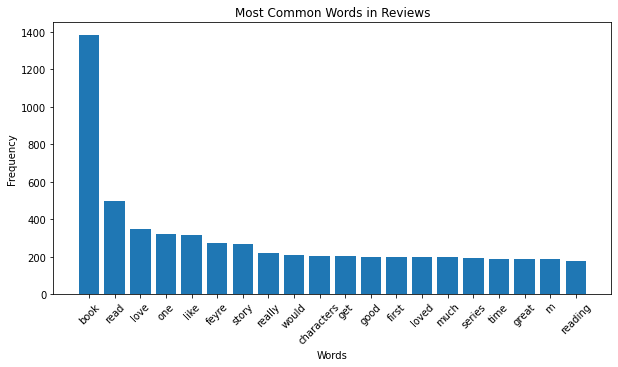

In [17]:
# List of common English stopwords
stopwords = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was',
    'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
    'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
    'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
])

def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase the text
        text = text.lower()
        # Remove punctuation and non-word characters
        text = re.sub(r'\W+', ' ', text)
        # Tokenize the text
        words = text.split()
        # Remove stopwords
        words = [word for word in words if word not in stopwords]
        return words
    else:
        return []

# Apply preprocessing to the 'body' column
data['processed_body'] = data['body'].apply(preprocess_text)

# Flatten the list of lists into a single list of words
all_words = [word for review in data['processed_body'] for word in review]

# Count the word frequencies
word_counts = Counter(all_words)

# Get the most common words
most_common_words = word_counts.most_common(20)

# Unzip the most common words and their counts
words, counts = zip(*most_common_words)

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.title('Most Common Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [18]:
# Define the preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\W+', ' ', text)
        words = text.split()
        stopwords = set([
            'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
            'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was',
            'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
            'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
            'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
            'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
            'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
            'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
        ])
        words = [word for word in words if word not in stopwords]
        return ' '.join(words)
    else:
        return ''

# Apply preprocessing
data['cleaned_body'] = data['body'].apply(preprocess_text)

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis
data['sentiment'] = data['body'].apply(lambda review: sid.polarity_scores(str(review)))

# Extract compound score for overall sentiment
data['compound'] = data['sentiment'].apply(lambda score_dict: score_dict['compound'])

# Determine sentiment label
data['sentiment_label'] = data['compound'].apply(lambda c: 'positive' if c > 0 else ('negative' if c < 0 else 'neutral'))

# Check if the sentiment labels are assigned correctly
print(data[['body', 'sentiment', 'compound', 'sentiment_label']].head())

# Define the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Prepare the feature matrix and target variable
X = tfidf.fit_transform(data['cleaned_body'])
y = data['sentiment_label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jaypa\AppData\Roaming\nltk_data...


                                                body  \
0  Great, great read. Very insightful and easy to...   
1  "The Psychology of Money: Timeless lessons on ...   
2  I like the book. It gave a perspective of to b...   
3  Very solid book that gives you the opportunity...   
4  Great insights and lessons for all. Psychololo...   

                                           sentiment  compound sentiment_label  
0  {'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'comp...    0.9556        positive  
1  {'neg': 0.018, 'neu': 0.803, 'pos': 0.179, 'co...    0.9919        positive  
2  {'neg': 0.125, 'neu': 0.694, 'pos': 0.181, 'co...    0.6249        positive  
3  {'neg': 0.015, 'neu': 0.889, 'pos': 0.096, 'co...    0.7715        positive  
4  {'neg': 0.05, 'neu': 0.775, 'pos': 0.176, 'com...    0.9700        positive  
Accuracy: 0.8333333333333334
Confusion Matrix:
[[  0   0  20]
 [  0   0  10]
 [  0   0 150]]
Classification Report:
              precision    recall  f1-score   support

    ne

c:\Users\jaypa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaypa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaypa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo